In [9]:
import numpy as np
import os
from astropy.io import fits
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import astropy.units as u
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from IPython.display import display, Image
from specutils import Spectrum1D, SpectralRegion
from spectral_cube import SpectralCube
from specutils.analysis import moment
from specutils.manipulation import spectral_slab
from astropy.modeling import models, fitting
from spectral_cube import SpectralCube
from scipy.ndimage import gaussian_filter, gaussian_laplace, find_objects
from scipy.optimize import curve_fit
from scipy.stats import kurtosis

In [10]:
def compute_and_plot_fourier(data, title_prefix, slice_index):
    # Assicurati che l'indice della slice sia valido
    if slice_index < 0 or slice_index >= data.shape[0]:
        raise ValueError(f"Indice della slice {slice_index} non valido. Deve essere tra 0 e {data.shape[0] - 1}.")

    # Calcola la trasformata di Fourier solo per la slice selezionata
    slice_data = data[slice_index]
    fourier_transform = np.fft.fftn(slice_data)
    magnitude_transform = np.abs(fourier_transform)
    phase_transform = np.angle(fourier_transform)

    plt.figure(figsize=(12, 6))

    # Magnitudine
    plt.subplot(1, 2, 1)
    plt.imshow(np.log1p(np.fft.fftshift(magnitude_transform)), cmap='gray', origin='lower')
    plt.title(f'{title_prefix} - Magnitudine Slice {slice_index}')
    plt.colorbar()

    # Fase
    plt.subplot(1, 2, 2)
    plt.imshow(np.fft.fftshift(phase_transform), cmap='hsv', origin='lower')
    plt.title(f'{title_prefix} - Fase Slice {slice_index}')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [11]:
def compute_and_plot_fourier_3d_full(data, title_prefix, projection_axis='xy'):

    # FT3d
    fourier_transform = np.fft.fftn(data)
    magnitude_transform = np.abs(fourier_transform)
    phase_transform = np.angle(fourier_transform)

    # Shift 
    magnitude_transform = np.fft.fftshift(magnitude_transform)
    phase_transform = np.fft.fftshift(phase_transform)

    # Projection
    if projection_axis == 'xy':
        magnitude_display = magnitude_transform[:, :, magnitude_transform.shape[2] // 2]
        phase_display = phase_transform[:, :, phase_transform.shape[2] // 2]
    elif projection_axis == 'xz':
        magnitude_display = magnitude_transform[:, magnitude_transform.shape[1] // 2, :]
        phase_display = phase_transform[:, phase_transform.shape[1] // 2, :]
    elif projection_axis == 'yz':
        magnitude_display = magnitude_transform[magnitude_transform.shape[0] // 2, :, :]
        phase_display = phase_transform[magnitude_transform.shape[0] // 2, :, :]
    else:
        raise ValueError(f"Invalid Projection Axis: {projection_axis}. Use 'xy', 'xz', o 'yz'.")
    
    magnitude_display = np.log1p(magnitude_display)
    plt.figure(figsize=(12, 6))

    
    plt.subplot(1, 2, 1)
    plt.imshow(magnitude_display, cmap='gray', origin='lower')
    plt.title(f'{title_prefix} - Magnitude')
    plt.colorbar()

    
    plt.subplot(1, 2, 2)
    plt.imshow(phase_display, cmap='hsv', origin='lower')
    plt.title(f'{title_prefix} - Phase')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [12]:
# filename = r"C:\Users\lsann\Desktop\Simulation\J0842_uid___A001_X2fb_X3ec_SNR0_IR18\dirty-cube_0.fits"

# # Load the data
# HDUL = fits.open(filename)
# data = HDUL[0].data  

# # Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
# integrated_flux = np.sum(data, axis=0)
# y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
# print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# # Step 2: Identify the slice that contains the maximum flux at the source coordinates
# # Extract the flux values at (x_center, y_center) across all slices
# source_spectrum = data[:, y_center, x_center]

# # Find the slice index with the maximum flux at the source coordinates
# max_slice_index_mock = np.argmax(source_spectrum)
# print(f"Slice with maximum flux at the source coordinates: {max_slice_index_mock}")

# # Extract the 2D data from this slice
# slice_data = data[max_slice_index_mock]

# # Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# # Create radial profile centered at (x_center, y_center)
# y, x = np.indices(slice_data.shape)
# r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
# r = r.astype(int)

# # Calculate the radial profile
# tbin = np.bincount(r.ravel(), slice_data.ravel())
# nr = np.bincount(r.ravel())
# radialprofile = tbin / nr

# # Apply smoothing to the radial profile to reduce noise
# radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# # Define the 90% of maximum flux threshold
# flux_threshold = 0.90 * np.max(radialprofile_smooth)

# # Find the radius where the radial profile drops to 90% of the maximum flux
# source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
# print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# # Estimate sigma as half of the radius (this is an approximation)
# sigma_fit = source_radius / 2.0
# print(f"Estimated sigma: {sigma_fit}")

# # Step 4: Calculate the background radius
# background_radius = int(3 * sigma_fit)
# print(f"Background radius: {background_radius}")

# # Step 5: Create masks for source and background regions based on the source slice
# source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
# background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
# background_mask &= ~source_mask

# # Step 6: Compute mean, standard deviation, and SNR for all slices
# mean_fluxes = []
# std_backgrounds = []
# snr_values = []

# for i in range(data.shape[0]):
#     slice_data = data[i]
    
#     # Mean of the source region in the current slice
#     mean_source = np.mean(slice_data[source_mask])
#     mean_fluxes.append(mean_source)

#     # Standard deviation of the background region in the current slice
#     std_background = np.std(slice_data[background_mask])
#     std_backgrounds.append(std_background)

#     # SNR for the current slice
#     snr = mean_source / std_background if std_background != 0 else 0
#     snr_values.append(snr)

# # Step 7: Calculate the overall SNR of the cube
# overall_snr = np.mean(snr_values)
# print(f"Overall SNR of the cube: {overall_snr}")
# kurt = kurtosis(slice_data.ravel(),fisher=True)
# print(f'Kurtosis is : {kurt}')

# # Step 8: Plot SNR across all slices
# plt.figure(figsize=(10, 6))
# plt.plot(range(data.shape[0]), snr_values, label='SNR')
# plt.xlabel('Slice Index')
# plt.ylabel('SNR')
# plt.title('SNR Across All Slices')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Step 9: Plot Mean Flux across all slices
# plt.figure(figsize=(10, 6))
# plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
# plt.xlabel('Slice Index')
# plt.ylabel('Mean Flux')
# plt.title('Mean Flux Across All Slices')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Step 10: Plot Standard Deviation across all slices
# plt.figure(figsize=(10, 6))
# plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
# plt.xlabel('Slice Index')
# plt.ylabel('Standard Deviation')
# plt.title('Standard Deviation Across All Slices')
# plt.grid(True)
# plt.legend()
# plt.show()

# # Step 11: Pixel flux distribution of the selected slice
# plt.figure(figsize=(10, 6))
# plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
# plt.xlabel('Pixel Flux')
# plt.ylabel('Number of Pixels')
# plt.title('Pixel Flux Distribution of the Selected Slice')
# plt.grid(True)
# plt.show()

# # Close the FITS file
# HDUL.close()

# # Visualize the regions if needed
# plt.figure(figsize=(6, 6))
# plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
# plt.title('Source (red) and Background (green) Regions')
# plt.colorbar(label='Region Mask')
# plt.show()



Overall SNR of the cube: 2.178734540939331
Kurtosis is : 0.002093777887399284


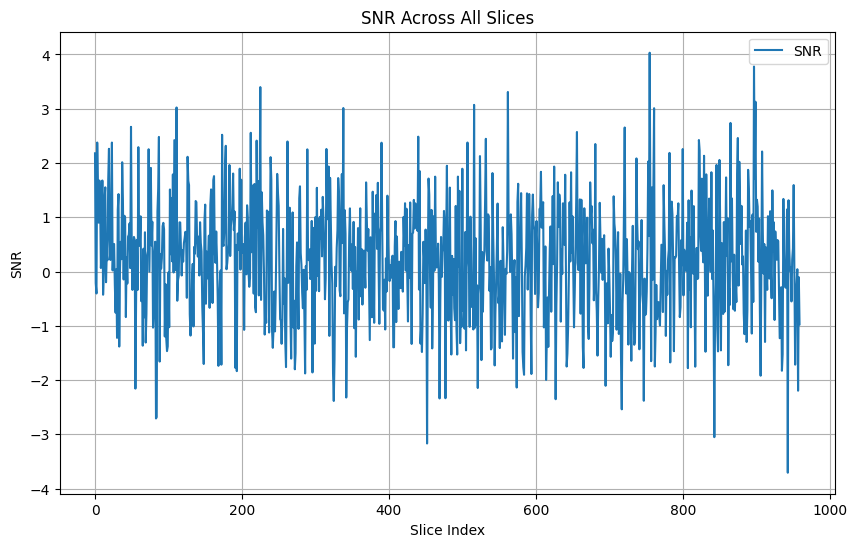

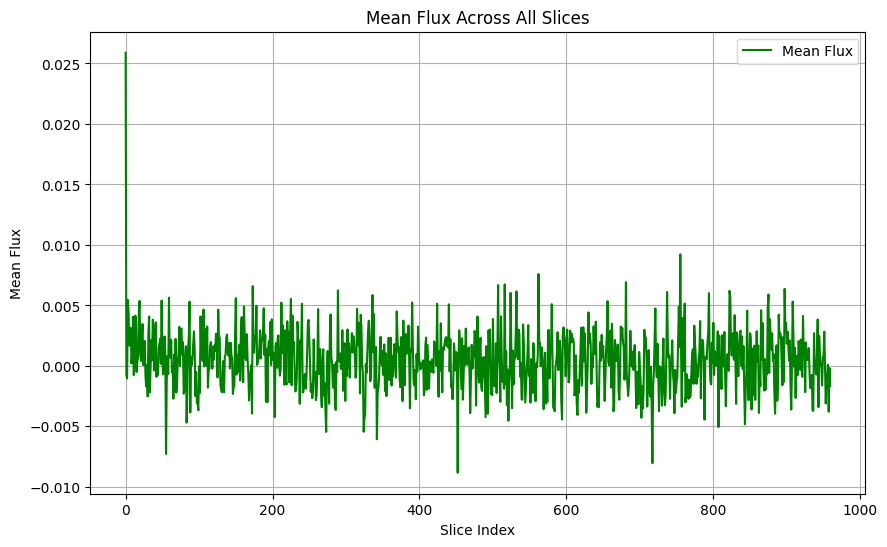

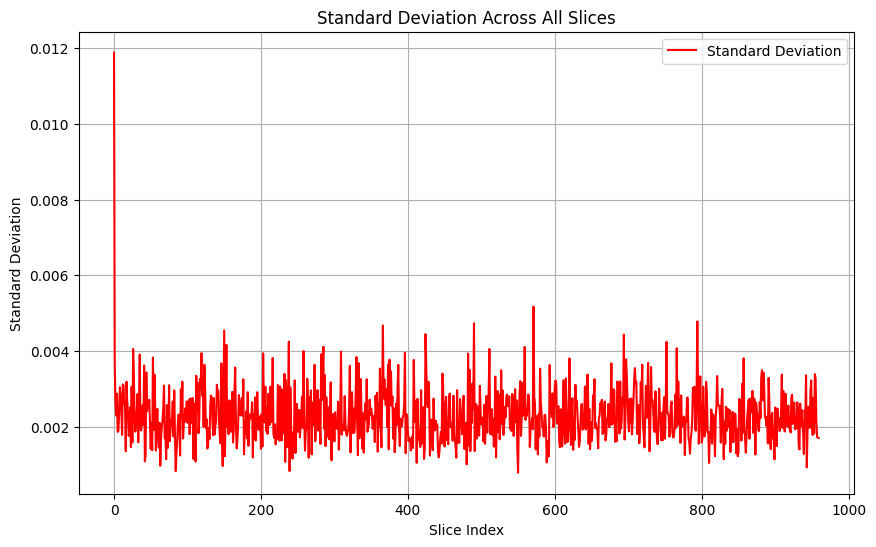

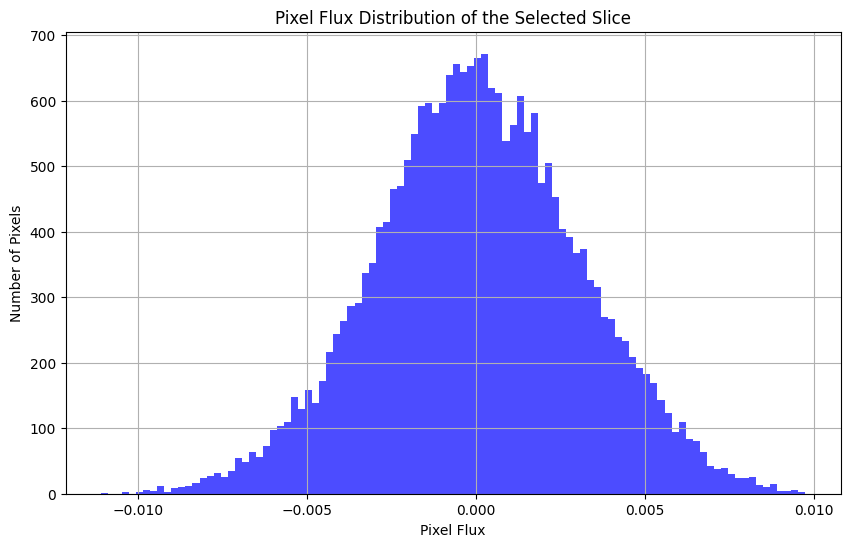

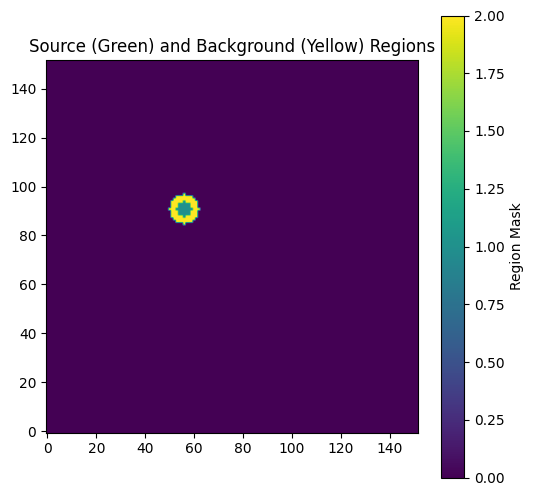

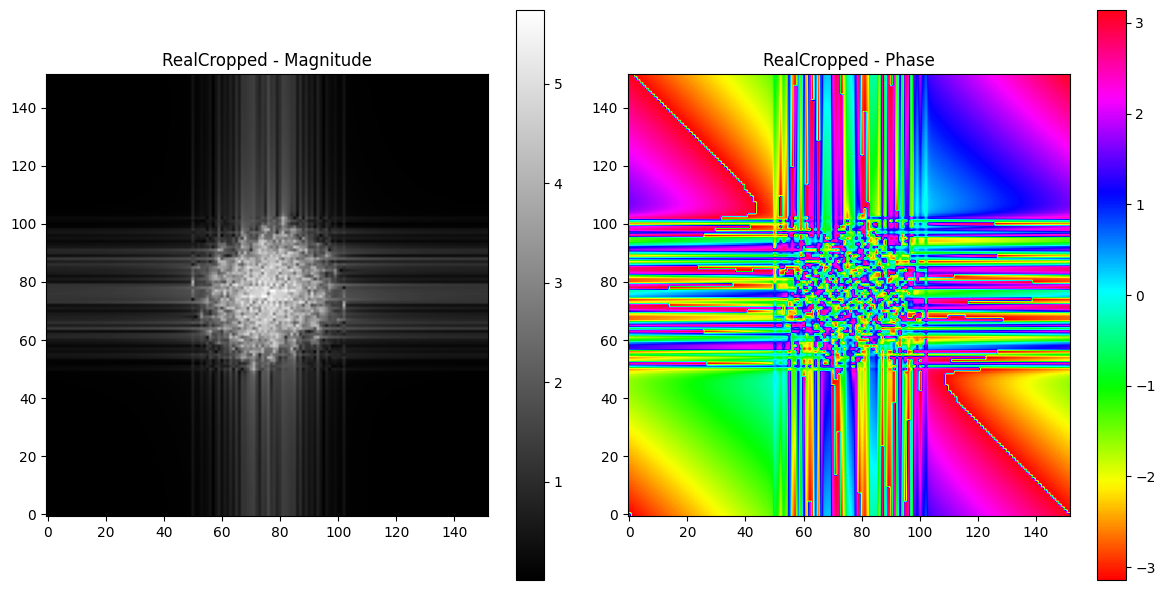

In [13]:
filename = r"C:\Users\lsann\Desktop\newtest\cropped_cubes\cropped_J0842.fits"

# Load the data
HDUL = fits.open(filename)
data = HDUL[0].data  

integrated_flux = np.sum(data, axis=0)

# Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center) in the integrated flux map
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)

# Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Calculate the source radius based on 90% of the maximum flux in the selected slice
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)
flux_threshold = 0.9 * np.max(radialprofile_smooth)
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:
    source_radius = np.argmax(radialprofile_smooth > 0)

sigma_fit = source_radius / 2.0

# Create masks for the source region and the background annulus
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Calculate mean source and standard deviation of background
mean_source = np.mean(slice_data[source_mask])
std_background = np.std(slice_data[background_mask])

 # Calculate the SNR for the selected slice
overall_snr = mean_source / std_background if std_background != 0 else 0

# Calculate kurtosis of the selected slice
kurt = kurtosis(slice_data.ravel(), fisher=True) if slice_data.size > 0 else 0

# Step 7: Calculate the overall SNR of the cube
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')
# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)
# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (Green) and Background (Yellow) Regions')
plt.colorbar(label='Region Mask')
plt.show()

compute_and_plot_fourier_3d_full(data, 'RealCropped', projection_axis='yz')

Overall SNR of the cube: 6.647187232971191
Kurtosis is : -0.06654838155268417


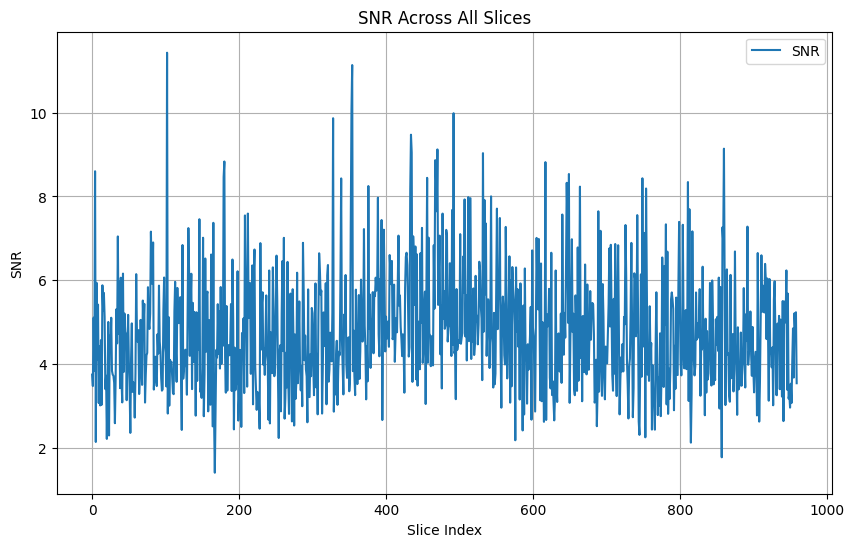

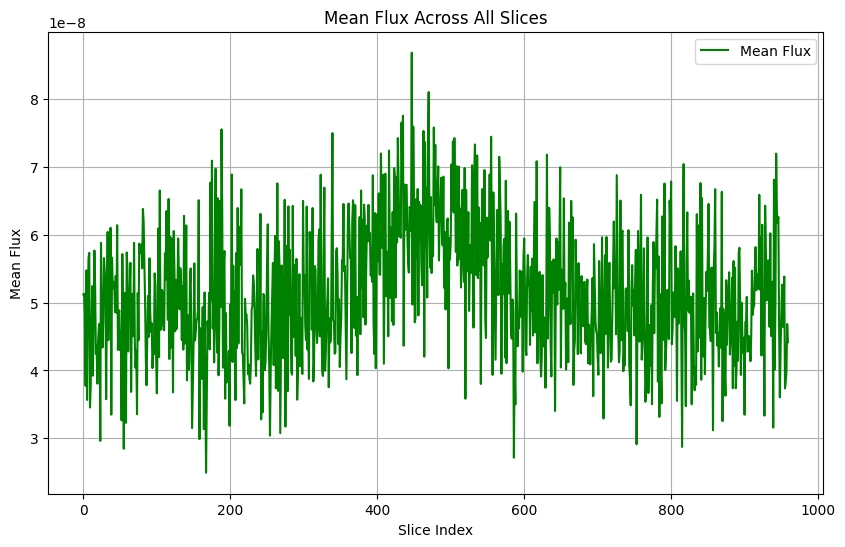

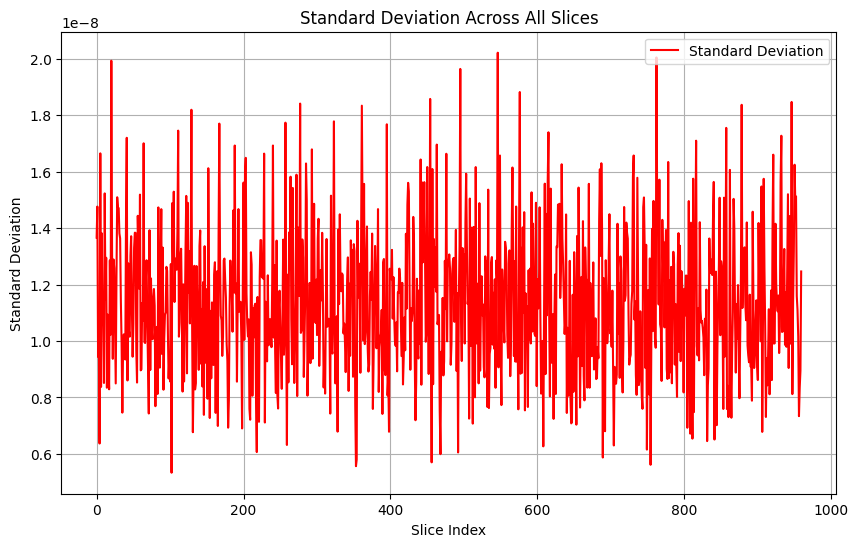

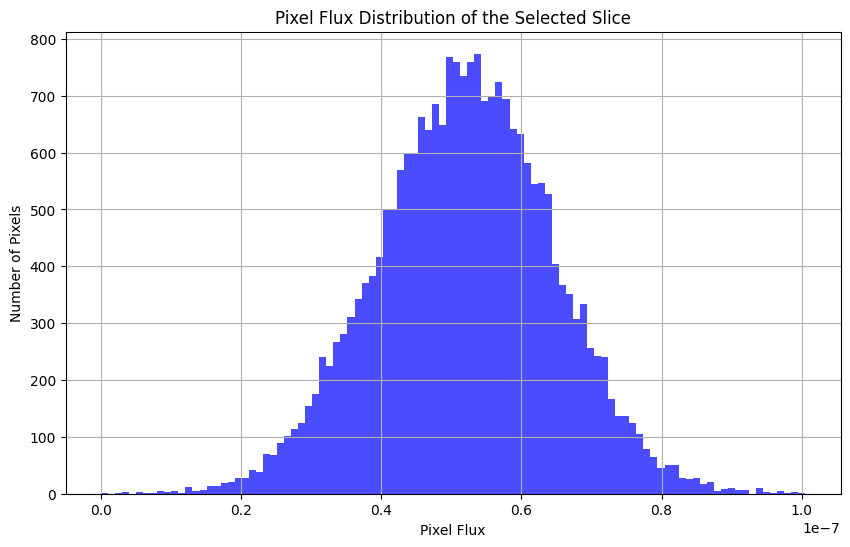

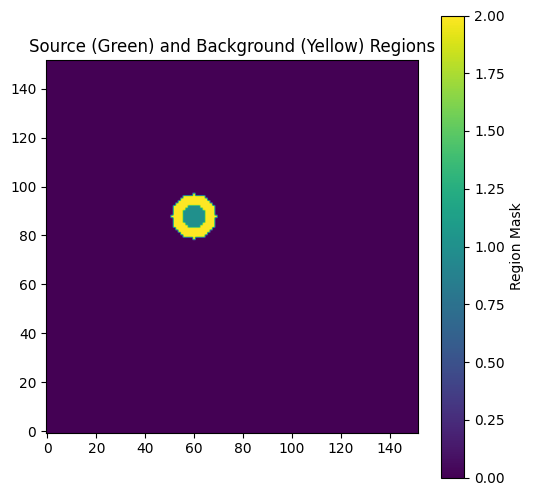

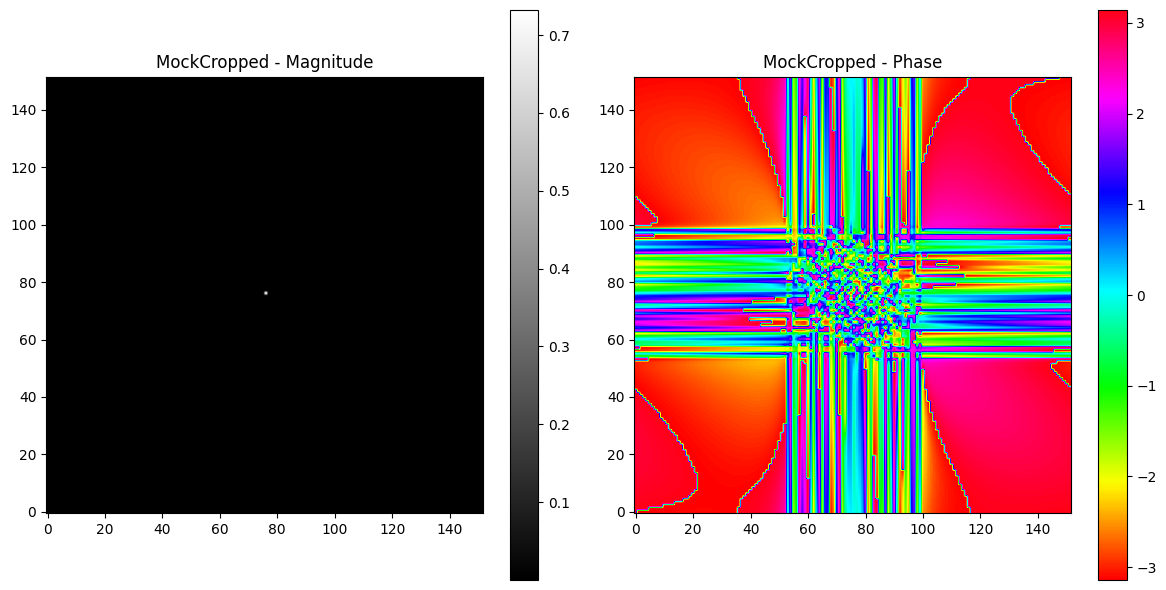

In [14]:
filename = r"C:\Users\lsann\Desktop\newtest\cropped_cubes\cropped_J0842_dirty_cube.fits"

# Load the data
HDUL = fits.open(filename)
data = HDUL[0].data  

integrated_flux = np.sum(data, axis=0)

# Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center) in the integrated flux map
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)

# Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Calculate the source radius based on 90% of the maximum flux in the selected slice
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)
flux_threshold = 0.9 * np.max(radialprofile_smooth)
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:
    source_radius = np.argmax(radialprofile_smooth > 0)

sigma_fit = source_radius / 2.0

# Create masks for the source region and the background annulus
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Calculate mean source and standard deviation of background
mean_source = np.mean(slice_data[source_mask])
std_background = np.std(slice_data[background_mask])

 # Calculate the SNR for the selected slice
overall_snr = mean_source / std_background if std_background != 0 else 0

# Calculate kurtosis of the selected slice
kurt = kurtosis(slice_data.ravel(), fisher=True) if slice_data.size > 0 else 0

# Step 7: Calculate the overall SNR of the cube
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')
# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)
# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (Green) and Background (Yellow) Regions')
plt.colorbar(label='Region Mask')
plt.show()

compute_and_plot_fourier_3d_full(data, 'MockCropped', projection_axis='yz')

Overall SNR of the cube: 6.647187232971191
Kurtosis is : 0.10748878332920464


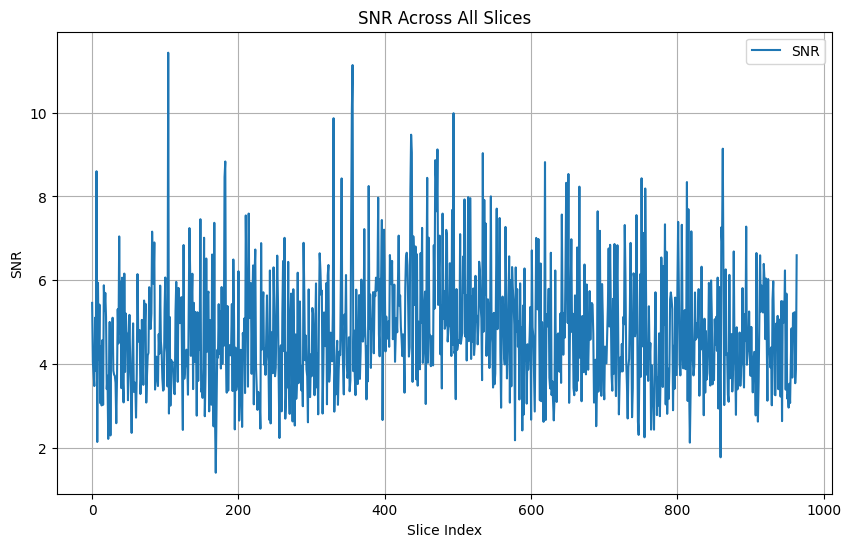

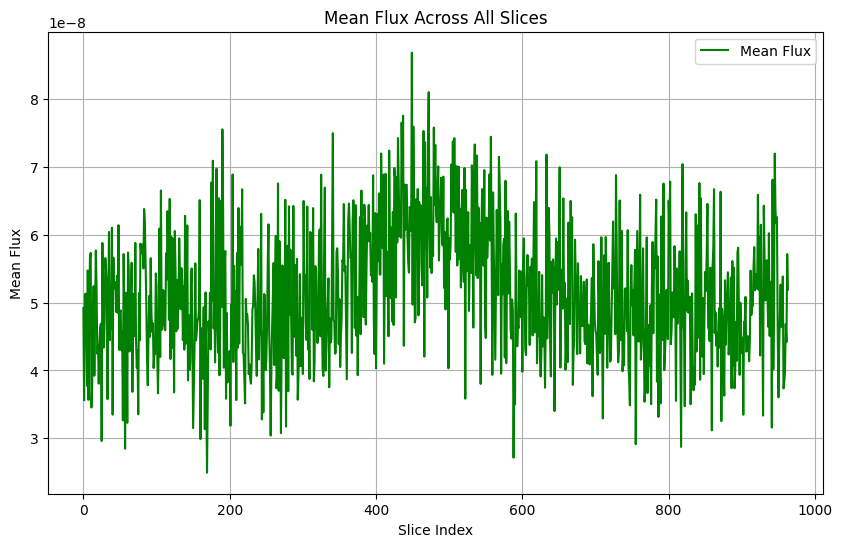

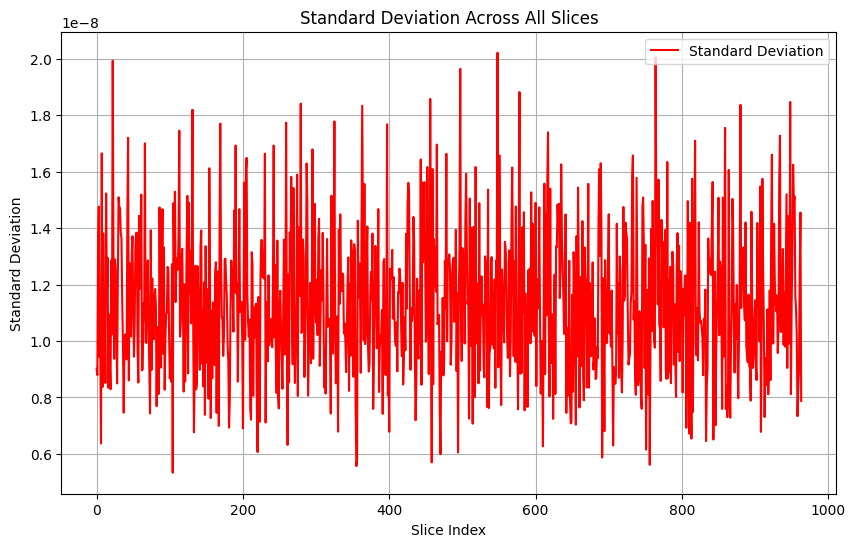

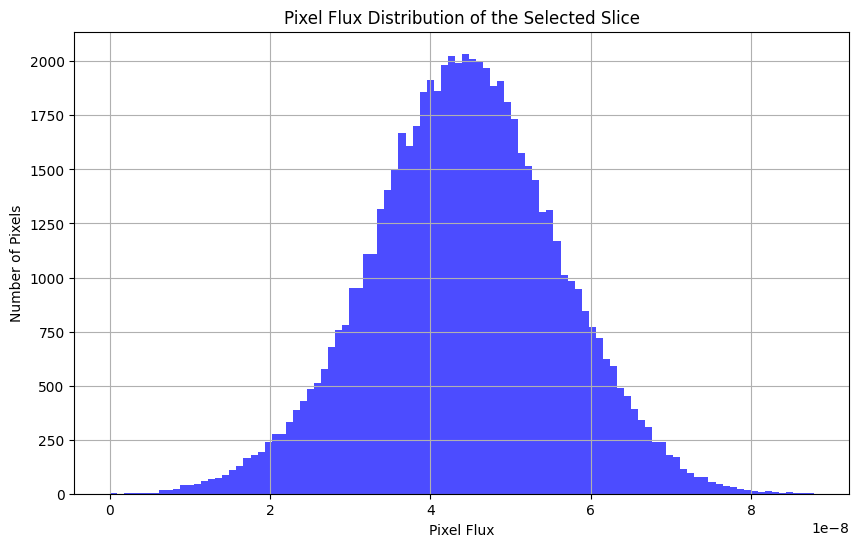

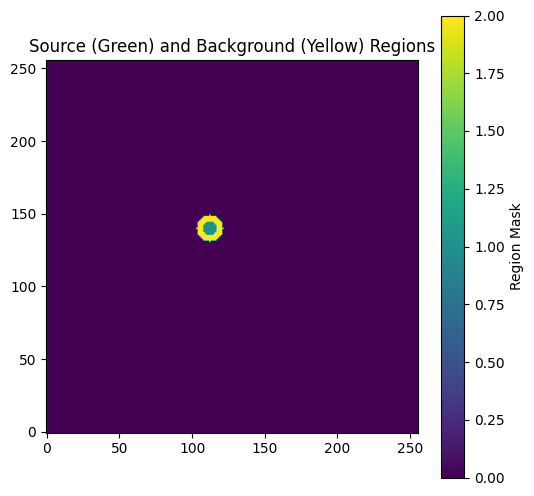

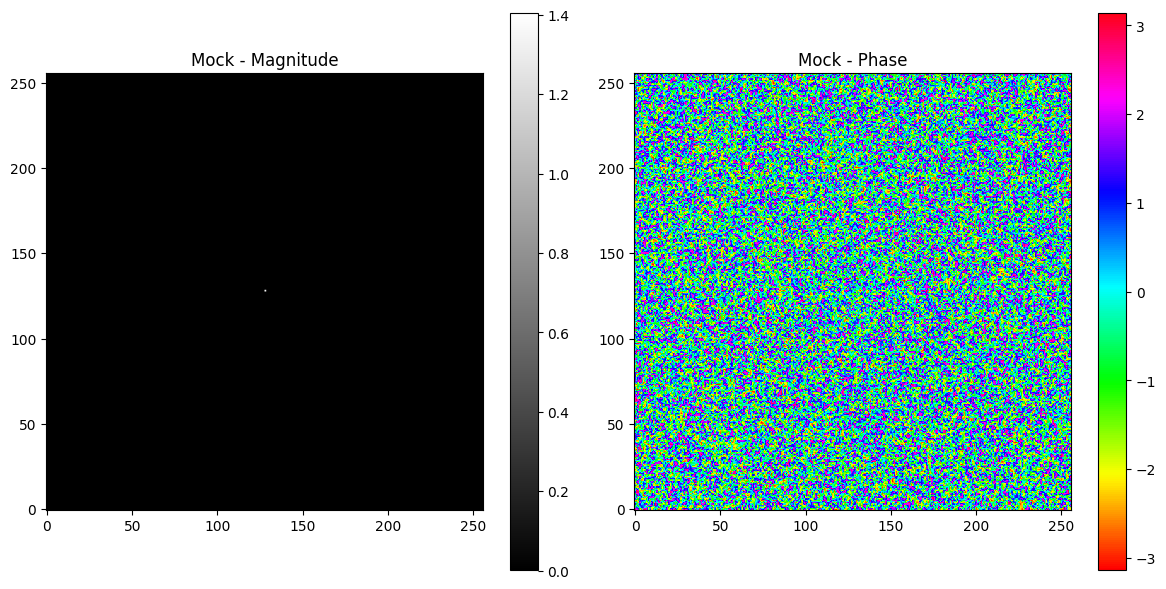

In [15]:
filename = r"C:\Users\lsann\Desktop\newtest\J0842\dirty-cube_0.fits"

# Load the data
HDUL = fits.open(filename)
data = HDUL[0].data  

integrated_flux = np.sum(data, axis=0)

# Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center) in the integrated flux map
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)

# Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Calculate the source radius based on 90% of the maximum flux in the selected slice
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)
flux_threshold = 0.9 * np.max(radialprofile_smooth)
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:
    source_radius = np.argmax(radialprofile_smooth > 0)

sigma_fit = source_radius / 2.0

# Create masks for the source region and the background annulus
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Calculate mean source and standard deviation of background
mean_source = np.mean(slice_data[source_mask])
std_background = np.std(slice_data[background_mask])

 # Calculate the SNR for the selected slice
overall_snr = mean_source / std_background if std_background != 0 else 0

# Calculate kurtosis of the selected slice
kurt = kurtosis(slice_data.ravel(), fisher=True) if slice_data.size > 0 else 0

# Step 7: Calculate the overall SNR of the cube
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')
# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)
# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (Green) and Background (Yellow) Regions')
plt.colorbar(label='Region Mask')
plt.show()

compute_and_plot_fourier_3d_full(data, 'Mock', projection_axis='yz')

Overall SNR of the cube: 2.178734540939331
Kurtosis is : 0.002093777887399284


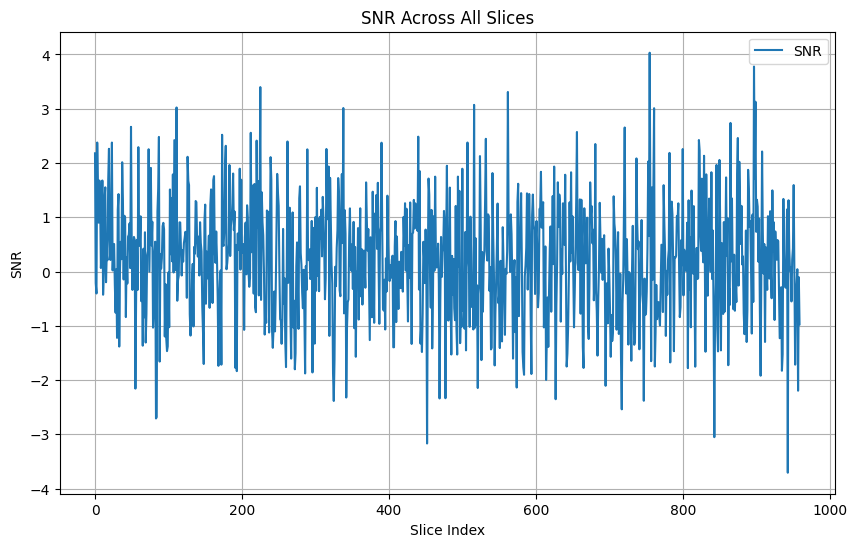

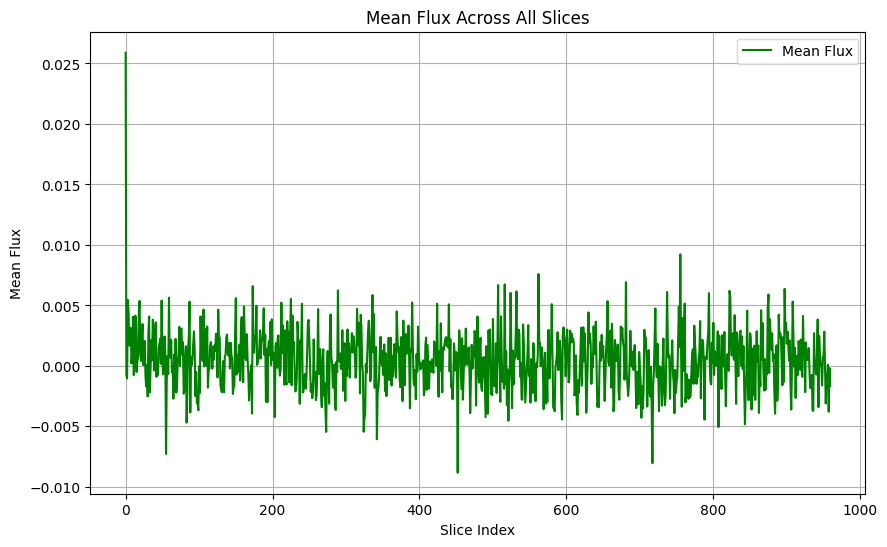

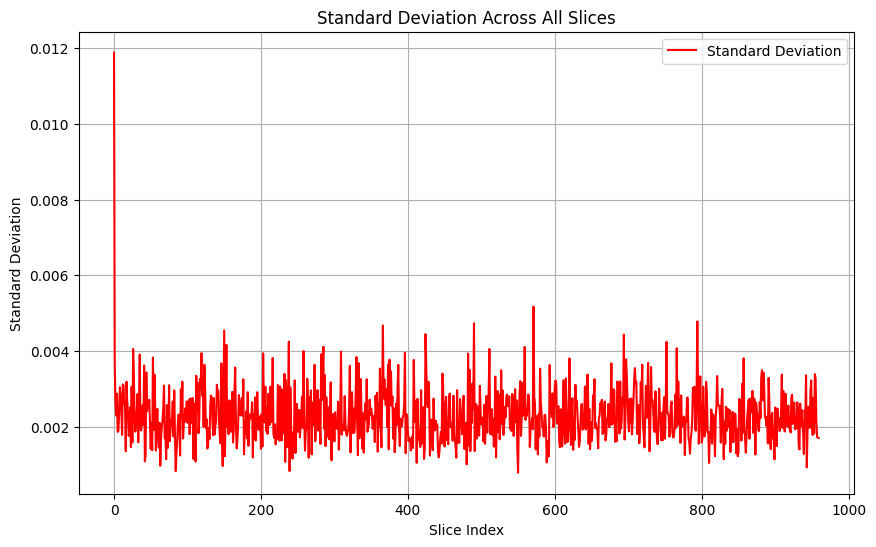

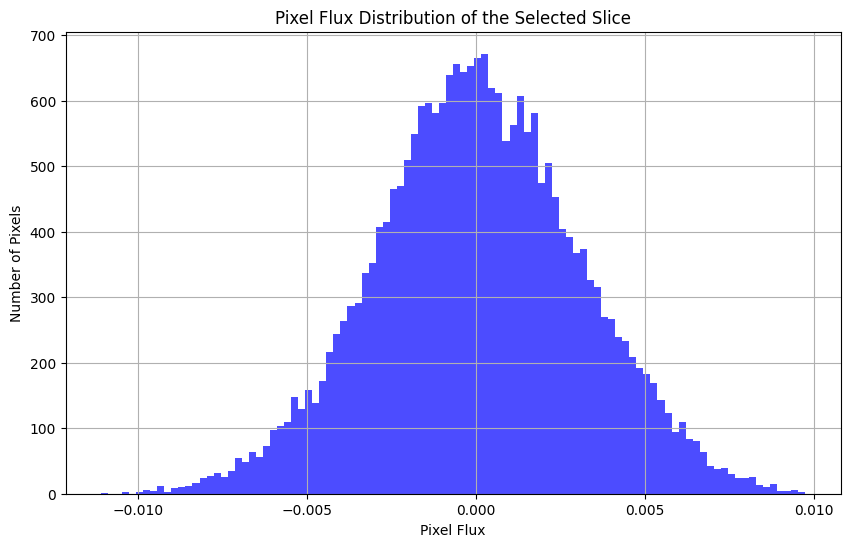

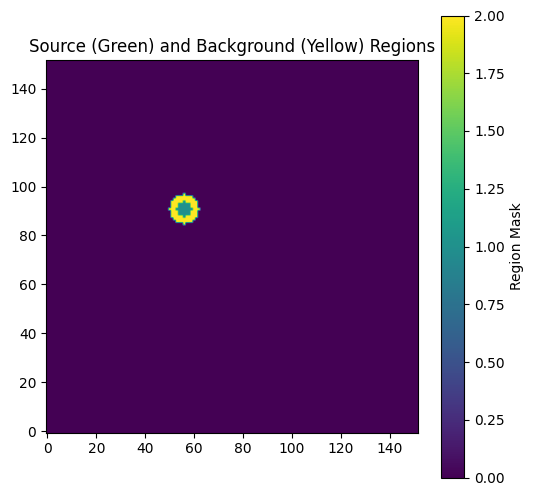

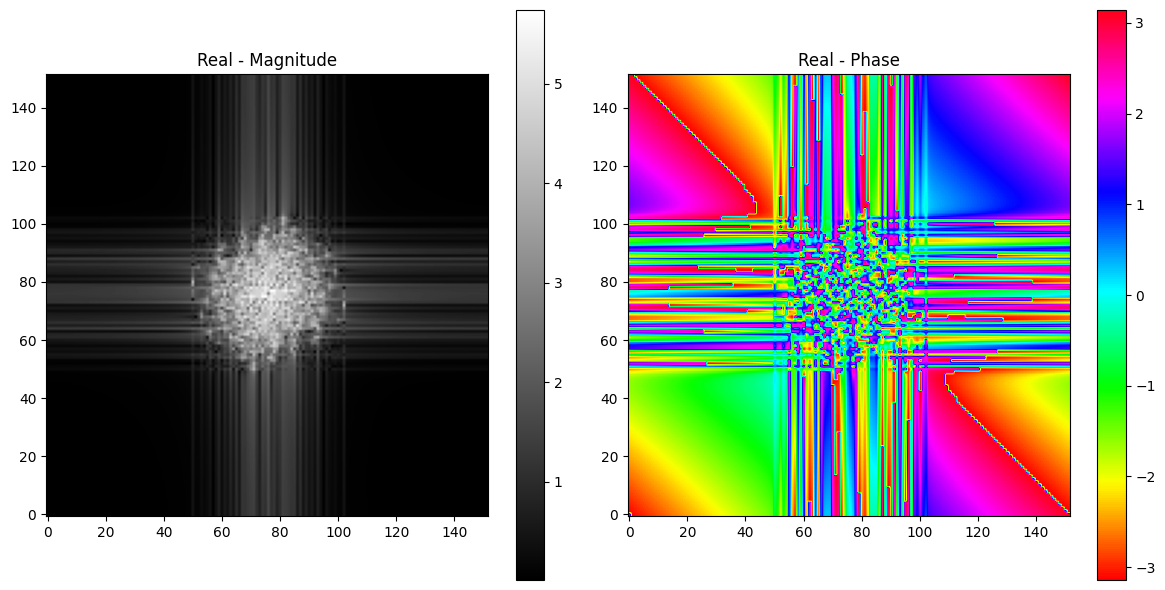

In [16]:
filename = r"C:\Users\lsann\Desktop\newtest\cropped_cubes\cropped_J0842SNR3.fits"

# Load the data
HDUL = fits.open(filename)
data = HDUL[0].data  
data = np.squeeze(data)

integrated_flux = np.sum(data, axis=0)

# Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center) in the integrated flux map
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)

# Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Calculate the source radius based on 90% of the maximum flux in the selected slice
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)
flux_threshold = 0.9 * np.max(radialprofile_smooth)
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:
    source_radius = np.argmax(radialprofile_smooth > 0)

sigma_fit = source_radius / 2.0

# Create masks for the source region and the background annulus
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Calculate mean source and standard deviation of background
mean_source = np.mean(slice_data[source_mask])
std_background = np.std(slice_data[background_mask])

 # Calculate the SNR for the selected slice
overall_snr = mean_source / std_background if std_background != 0 else 0

# Calculate kurtosis of the selected slice
kurt = kurtosis(slice_data.ravel(), fisher=True) if slice_data.size > 0 else 0

# Step 7: Calculate the overall SNR of the cube
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')
# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)
# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (Green) and Background (Yellow) Regions')
plt.colorbar(label='Region Mask')
plt.show()

compute_and_plot_fourier_3d_full(data, 'Real', projection_axis='yz')